# DT logs prediction model

## Contents

* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Model training](#Model-training)
* [Inference](#Inference)
* [Metrics evaluation](#Metrics-evaluation)
* [Conclusion](#Conclusion)

## Problem description

Predict DT logs values based on other logs values and depth info.

In [2]:
%env CUDA_VISIBLE_DEVICES='1'

import os
import sys

import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, "/notebooks/goryachev/petroflow")

from petroflow import WellDataset, WS
from petroflow.batchflow import Pipeline, B, V
from petroflow.batchflow.models.torch import TorchModel
from petroflow.models.logs_prediction.utils import build_dataset, calc_metrics, moving_average_1d

env: CUDA_VISIBLE_DEVICES='1'


## Dataset

A datased of 620 wells with filtered wells data.

In [4]:
FILTERED_DATASET_PATH = "../data/filtered/*"
filtered_dataset = WellDataset(path=FILTERED_DATASET_PATH, dirs=True)

DT values are predicted by GK, NKTD and GZ1 logs and depth info.

In [11]:
INPUTS_COL = ['GK', 'NKTD', 'GZ1', "DEPTH KM"]
TARGET_COL = ['DT']
PROPER_COL = INPUTS_COL + TARGET_COL

8 crops of length 6.4m will be sampled from each well in a batch.

In [6]:
N_CROPS = 8
CROP_SIZE = 64
REINDEXATION_STEP = 0.1
CROP_LENGTH = CROP_SIZE * REINDEXATION_STEP

Split logs by non nan segments.

In [7]:
split_pipeline = filtered_dataset >> Pipeline().drop_nans()
batch = split_pipeline.next_batch(filtered_dataset.size)
dataset = build_dataset(batch)
dataset.split(shuffle=11)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



## Model architecture

Network of two dense layers is used for prediction:

* Second dense layer is preceded by activation and normalization layers.

* LeakyRelu is used as activation function.

* Adam optimizer with default parameters is used for model training. 

* Mean-squared error is used as a loss function.

Model configuration specification:

In [8]:
INPUTS_SIZE = len(INPUTS_COL)
TARGET_SIZE = len(TARGET_COL)

model_config = {
    'initial_block/inputs': 'inputs',
    'inputs/inputs': {'shape': [INPUTS_SIZE, CROP_SIZE]},
    'inputs/target': {'shape': [CROP_SIZE]},
    'loss': 'mse',
    'optimizer': 'Adam',
    'body/units': [CROP_SIZE*10, CROP_SIZE],
    'body/layout': 'fan f',
    'body/activation' : 'LeakyRelu',
    'device' : torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
}

## Model training

In [15]:
train_template = (Pipeline()
    .add_namespace(np)
    .random_crop(CROP_LENGTH, N_CROPS)
    .update(B('inputs'), WS('logs')[INPUTS_COL].values.ravel())
    .stack(B("inputs"), save_to=B("inputs"))
    .swapaxes(B("inputs"), 1, 2, save_to=B("inputs"))
    .array(B("inputs"), dtype=np.float32, save_to=B("inputs"))
    .update(B('target'), WS('logs')[TARGET_COL].values.ravel())
    .stack(B("target"), save_to=B("target"))
    .squeeze(B("target"), save_to=B("target"))
    .array(B("target"), dtype=np.float32, save_to=B("target"))
    .init_variable('train_loss', default=[])
    .init_model('dynamic', TorchModel, 'linear', model_config)
    .train_model('linear', B('inputs'), B('target'), fetches='loss', save_to=V('train_loss', mode='a'))
)

train_pipeline = dataset.train >> train_template

The model is trained for 50 epochs with a batch size of 32.

In [25]:
BATCH_SIZE = 32
N_EPOCHS = 100
train_pipeline.run(batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, shuffle=True, drop_last=True, bar=True)



  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 1/1500 [00:01<28:07,  1.13s/it]

  0%|          | 2/1500 [00:02<26:58,  1.08s/it]

  0%|          | 3/1500 [00:03<26:29,  1.06s/it]

  0%|          | 4/1500 [00:04<26:04,  1.05s/it]

  0%|          | 5/1500 [00:05<26:29,  1.06s/it]

  0%|          | 6/1500 [00:06<25:47,  1.04s/it]

  0%|          | 7/1500 [00:07<25:47,  1.04s/it]

  1%|          | 8/1500 [00:08<25:34,  1.03s/it]

  1%|          | 9/1500 [00:09<25:44,  1.04s/it]

  1%|          | 10/1500 [00:10<26:11,  1.05s/it]

  1%|          | 11/1500 [00:11<26:28,  1.07s/it]

  1%|          | 12/1500 [00:12<26:14,  1.06s/it]

  1%|          | 13/1500 [00:13<26:06,  1.05s/it]

  1%|          | 14/1500 [00:14<26:31,  1.07s/it]

  1%|          | 15/1500 [00:15<25:15,  1.02s/it]

  1%|          | 16/1500 [00:16<25:01,  1.01s/it]

  1%|          | 17/1500 [00:17<24:17,  1.02it/s]

  1%|          | 18/1500 [00:18<23:50,  1.04it/s]

  1%|▏         | 19/1500 [00:19<24:06,  1.02it/

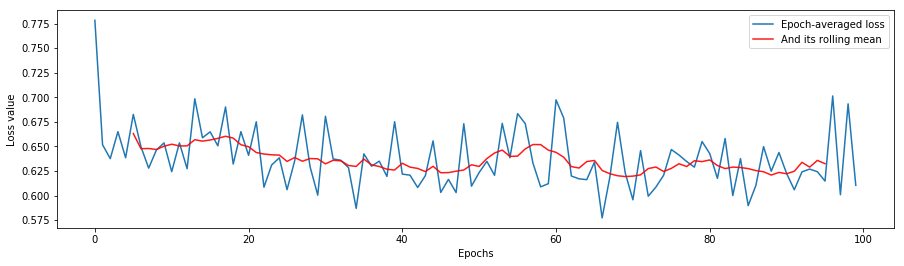

In [26]:
loss_history = train_pipeline.get_variable("train_loss")
epoch_averaged = np.array([np.mean(l) for l in np.array_split(loss_history, N_EPOCHS)])
rolling_averaged = moving_average_1d(epoch_averaged, 10)

fig = plt.figure(figsize=(15, 4))
plt.plot(epoch_averaged)
plt.plot(rolling_averaged, 'r', alpha=0.9)
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.legend(["Epoch-averaged loss", "And its rolling mean"])
plt.show()

Training loss almost reaches a plateau by the end of the training, meaning that the learning process has converged, but loss value is still far from zero.

## Inference

Inference pipeline is similar to the training one, except for two major differences:
* `random_crop` method is changed to `crop`
* test targets and model predictions are saved to pipeline `targets` and `predictions` variables correspondingly

In [27]:
test_template = (Pipeline()
    .add_namespace(np)
    .crop(CROP_LENGTH, CROP_LENGTH)
    .update(B('inputs'), WS('logs')[INPUTS_COL].values.ravel())
    .stack(B("inputs"), save_to=B("inputs"))
    .swapaxes(B("inputs"), 1, 2, save_to=B("inputs"))
    .array(B("inputs"), dtype=np.float32, save_to=B("inputs"))
    .update(B('target'), WS('logs')[TARGET_COL].values.ravel())
    .stack(B("target"), save_to=B("target"))
    .squeeze(B("target"), save_to=B("target"))
    .array(B("target"), dtype=np.float32, save_to=B("target"))
    .init_variable('targets', default=[])
    .update(V('targets', mode='a'), B('target'))
    .init_variable('predictions', default=[])
    .import_model('linear', train_pipeline)
    .predict_model('linear', B('inputs'), fetches='predictions', save_to=V('predictions', mode='a'))
)

## Metrics evaluation

Two metrics used for model evaluation:
* Mean squared error (MSE)
* proportion of variance explained by model to data variance (R^2)

Predict DT values on single batch.

In [24]:
test_pipeline = dataset.test >> test_template
test_pipeline.run(batch_size=1, n_iters=1, shuffle=True, drop_last=False)

true = np.concatenate([target.flatten() for target in test_pipeline.v('targets')])
pred = np.concatenate([prediction.flatten() for prediction in test_pipeline.v('predictions')])

metrics = calc_metrics(true, pred)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



MSE: 1.099
R^2: -0.385


Plot several randomly chosen predictions.

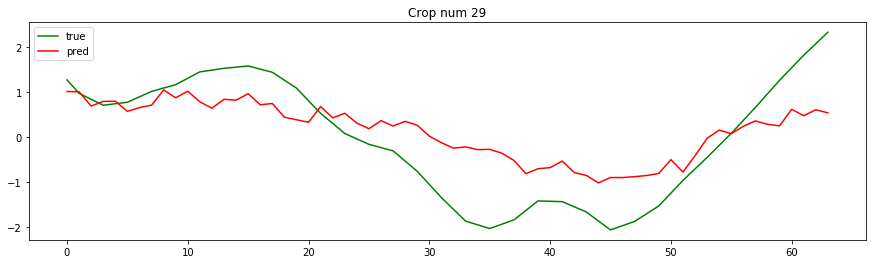

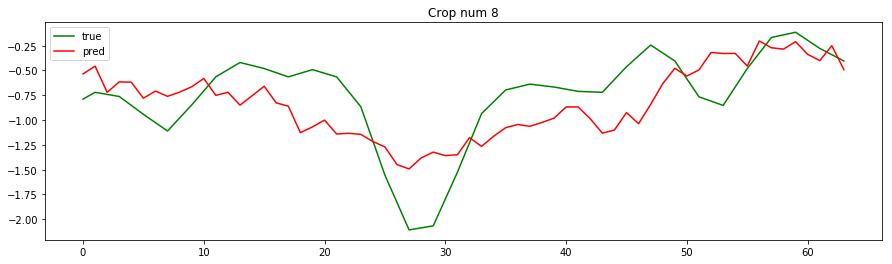

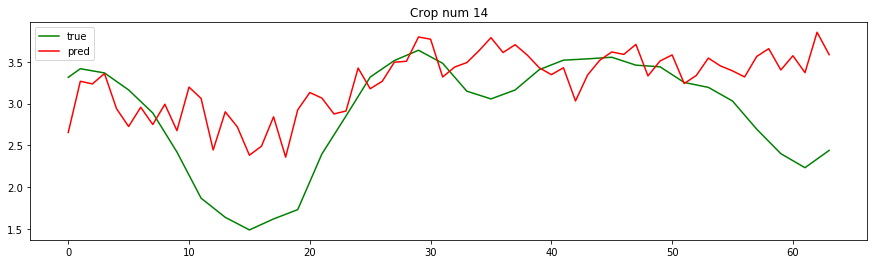

In [20]:
BATCH_NUM = np.random.randint(len(test_pipeline.v('predictions')))
GRAPH_NUM = test_pipeline.v('predictions')[BATCH_NUM].shape[0]
PRINT_NUM = 3
for crop_num in np.random.choice(GRAPH_NUM, PRINT_NUM, replace=False):
    true = test_pipeline.v('targets')[BATCH_NUM][crop_num,:]
    pred = test_pipeline.v('predictions')[BATCH_NUM][crop_num,:]

    fig = plt.figure(figsize=(15, 4))
    plt.title("Crop num {}".format(crop_num))
    plt.plot(true, 'g')
    plt.plot(pred, 'r')
    plt.legend(['true', 'pred'])
    plt.show()

Calculate metrics on whole test dataset

In [28]:
test_pipeline = dataset.test >> test_template
test_pipeline.run(batch_size=dataset.test.size, n_iters=1, drop_last=False)

true = np.concatenate([target.flatten() for target in test_pipeline.v('targets')])
pred = np.concatenate([prediction.flatten() for prediction in test_pipeline.v('predictions')])

metrics = calc_metrics(true, pred)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



MSE: 0.634
R^2: 0.351


In [29]:
with open("../linear/metrics", 'rb') as f:
    saved_metrics = pickle.load(f)
linear = [np.round(v, 3) for v in saved_metrics.values()]
dense = [np.round(v, 3) for v in metrics.values()]
pd.DataFrame(index=metrics.keys(), data=np.array([linear, dense]).T, columns=['linear', 'dense'])

,linear,fanf
MSE,0.646,0.634
R^2,0.338,0.351


## Conclusion

Metrics values on test dataset are just slightly better than in case of linear regression model, and therefore difference between models performance is not statistically significant.

Save model.

In [30]:
train_pipeline.get_model_by_name('linear').save('model')

with open('loss', 'wb') as f:
    pickle.dump(train_pipeline.get_variable('train_loss'), f)
    
with open('metrics', 'wb') as f:
    pickle.dump(metrics, f)